# TD1 exo 3 : fenêtrage et échantillonnage

Le signal à 60Hz est $s_F(t)=\sin(2\pi F t)$ de période T=1/F.

Il est échantillonné à 500 Hz avec une péridode d'échantillonnage $T_e=1/F_e$

Avec $N=64$ points, on obtient une durée d'observation $T_0=N\,T_e$ qui provoque une résolution fréquentielle de FFT $\Delta_f=\frac{1}{T_0}=\frac{F_e}{N}$

On remarque que le signal n'est pas observé sur des périodes entières car $T_0/T$ n'est pas entier !

T =  0.016667
Te =  0.0020000
T0 =  0.12800
T0surT =  7.6800


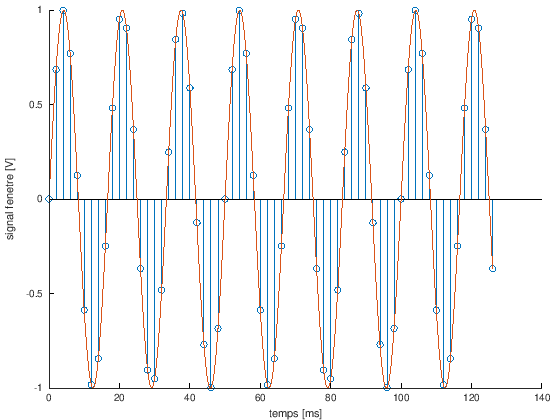

In [1]:
clear all; close all;
F=60;
T=1/F
s = @(t) sin(2*pi*F*t);

Fe=500; Te=1/Fe     % freq fft 64 points
N=64; k=1:N; k=k-1;t=k*Te; %temps discret
             
T0=N*Te             % période observation
Df=1/T0; f=k*Df;    % résolution fréquence

T0surT=T0/T        % problème de période T / T0

t_continu=t(1):Te/10:t(end);  % pour afficher sinus
stem(t*1000,s(t));hold on;
plot(t_continu*1000,s(t_continu))
xlabel("temps [ms]")
ylabel("signal fenetre [V]")

## FFT numérique et problème
Si l'on calcule la fft (ou tfd) du signal on s'attend à obtenir des pics à 60Hz, -60Hz et leurs alias périodiques aux fréquences $n\,F_e+60$ et $n\,F_e-60$.

Or comme la période d'observation $T_0=N T_e$ n'est pas un multiple exact de la période $T=1/60$ du sinus, la fréquence $F=60$Hz est mal échantillonnée. Car si l'on utilise la relation $f=n\,\Delta_f$ pour trouver le rang $n_F$ qui correspond à 60 Hz :
$$
n_F=\frac{F}{\Delta_f}=\frac{F}{\frac{F_e}{N}}=\frac{N\,F}{F_e}=\frac{64\,.\,60}{500}=\frac{N\,T_e}{T}=\frac{T_0}{T}=7,68
$$
Les pics (maximum d'amplitude) sont donc entre $\hat{S}[7]$ et $\hat{S}[8]$ pour 60 Hz et $\hat{S}[64-8]$ et $\hat{S}[64-7]$ pour $F_e-60$ Hz

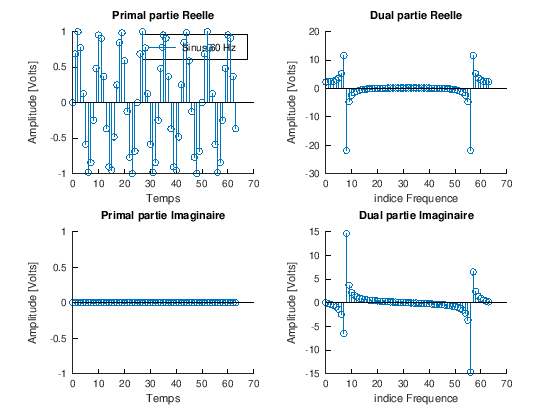

In [2]:
n=1:N; n=n-1; %indice des fréquences

plot_dual(k,"Temps",
        s(t),"Amplitude [Volts]",
        n,"indice Frequence",
        fft(s(t)),"Amplitude [Volts]",
        ["Sinus 60 Hz"],
        primalDiscret=true,
        dualDiscret=true)


# TF du signal fenêtré
Si nous somme loin de deux jolis pics ressemblant aux Diracs de la transformée d'un sinus, c'est un d'abord un effet du fenêtrage : **le fait d'observer le signal sur une durée finie (fenêtre d'observation) modifie le spectre du signal**.

C'est comme si le sinus de durée infinie est multiplié par une fonction de fenêtrage qui vaut 1 quand on observe le signal et 0 ailleurs : **la fonction porte est la fenêtre naturelle d'observation**~:
$$
\Pi_{[0 \,;\,N T_e]}(t) = \left\{ \begin{array}{ll} 1 \quad & \text{si } 0 < t < N\,T_e \\  0 & \text{sinon} \end{array} \right.
$$

On calcule la transformée de Fourier du signal fenêtré $(t)=s_F(t).\Pi_{[0 \,;\,N T_e]}(t)$ ce qui donne la convolution de deux dirac avec un sinus cardinal :
$$
\widehat{S}(f)=\underbrace{\frac{\delta_{F}-\delta_{-F}}{2i}}_{\widehat{S_F}(f)} * \underbrace{T_0\,\textrm{sinc}(\pi f\,T_0)}_{\widehat{\Pi}_{[0 \,;\,N T_e]}}
$$

Comme convoluer avec un Dirac c'est décaler le spectre (dual du théorème du retard avec Laplace) on obtient, et comme la période d'observation $T_0=N\,T_e=\frac{1}{\Delta_f}$ est liée à la résolution fréquentielle $\Delta_f=\frac{1}{T_0}=\frac{F_e}{N}$ :

$$
\widehat{S}(f)=\frac{T_0}{2i}\textrm{sinc}(\pi (f-F)\,T_0) -\frac{T_0}{2i}\textrm{sinc}(\pi (f+F)\,T_0)
$$



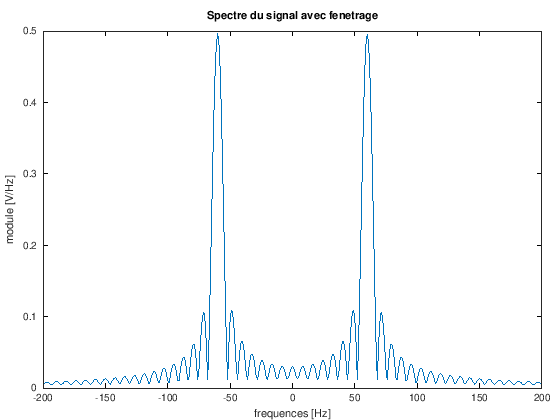

In [3]:
Sporte= @(f) T0*sinc(f*T0);           % porte centrée largeur T0
Sretard= @(f,tau) exp(-tau*i*2*pi*f) ; % retard de tau
Sfenetre= @(f) Sretard(f,T0/2).* Sporte(f); % porte 0 à T0

Sf = @(f) 1/(2*i)*(-Sfenetre(f+F)+Sfenetre(f-F));
f=-200:200;
plot(f,abs(Df*Sf(f)));hold on;
xlabel("frequences [Hz]")
ylabel("module [V/Hz]")
title("Spectre du signal avec fenetrage")


On voit que **le spectre de diracs aux fréquences -60 et 60 est comme filtré par le spectre de la fenêtre d'observation en sinus cardinal**

En effet filtrer un signal $x(t)$ dans le temps avec une réponse impulsionnelle $h(t)$ en calculant la convolution $x * h (t)$ c'est multiplier les spectres $X(f).H(f)$

**Le fenêtrage est le dual du filtrage** car on filtre un spectre $X(f)$ avec le spectre $H(f)$ en calculant la convolution $X * H (f)$, ce qui est simplement multiplier dans le temps $x(t).h(t)$.

**Plus la fenêtre d'observation est longue, plus le spectre de fenêtrage H(f) se rapproche d'un Dirac et moins le spectre X(f) est modifié.**.

Pour voir cela, il suffit de faire tendre $T_0$ vers l'infini dans  $H(f)=T_0\,\textrm{sinc}(\pi T_0\,f) $

## TFSD et période du spectre
Le signal temporel est discrétisé en multipliant le signal coninu par un peigne de Dirac de largeur $T_e$.

Pour avoir la TFSD on rend le spectre périodique en convoluant le spectre avec un peigne de Dirac d'amplitude 1/Te et de largeur Fe car **la transformée d'un peigne de Dirac de période $T_e$ est un peigne de Dirac de poids $F_e$ et période $F_e$**

Remarquez que comme le sinus cardinal est à support infini, le spectre $\hat{S}(f)$ contient des composantes (assez faibles) aux fréquences supérieures à $\frac{F_e}{2}$ il y a donc un léger repliement du spectre $\hat{S}(f)$. **le signal est coupé par la fenêtre, ce qui crée une discontinuité et fait apparaître des hautes fréquences qui se replient lors de l'échantillonnage**



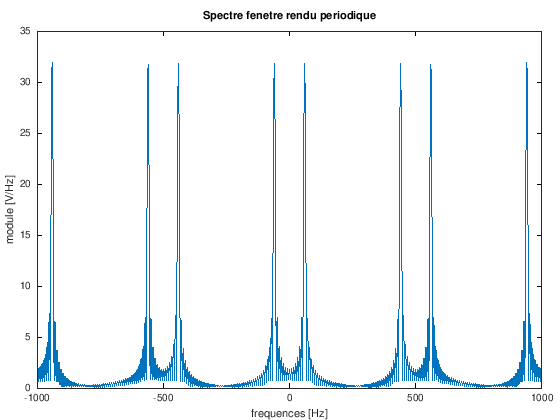

In [4]:
tfsd = @(f) 1/Te*Sf(f) + 1/Te*Sf(f-Fe)  + 1/Te*Sf(f+Fe) + ...
 1/Te*Sf(f-2*Fe)  + 1/Te*Sf(f+2*Fe);

f=-1000:1000;
plot(f,abs(tfsd(f)));hold on;
xlabel("frequences [Hz]")
ylabel("module [V/Hz]")
title("Spectre fenetre rendu periodique")



Dans la TFSD fenêtrée, on considère un signal de durée infinie, discrétisé dans le temps  mais qui a été annulé en dehors de la période d'observation.

**La TFSD est $F_e$ périodique mais incalculable, sur un processeur,  pour toute fréquence dans la fenêtre fréquentielle $f\in[0 \,;\, F_e]$ continues** la mémoire serait saturée.

On échantillonne donc la TFSD sur N points, N correspondant au nombre d'échantillons observés non nul, ce qui permet de ne pas perdre d'information et de ne pas calculer la transformée pour des fréquences inutiles.

**La TFD échnatillonne le spectre TFSD pour N fréquences réparties entre 0 et $F_e$, pour un signal observé de N points, ce nombre minimal de points permet de ne pas perdre d'information.**

## TFD et échantillonnage

la TFD échantillonne la TFSD avec une résolution $\Delta_f=\frac{F_e}{N}$ et la relation $f=n\,\Delta_f$ :

$$
\textrm{tfd}[n] = \textrm{TFSD}(n\Delta_f)=\textrm{TFSD}(\frac{n}{N}\,Fe)
$$

où la valeur $\frac{n}{N}$ est la fréquente normalisée entre $0$ et $1$ utilisé lorsque l'information $F_e$ n'est pas disponible ou sans intérêt : on considère $F_e=1$ par défaut.



ans =  7.6800


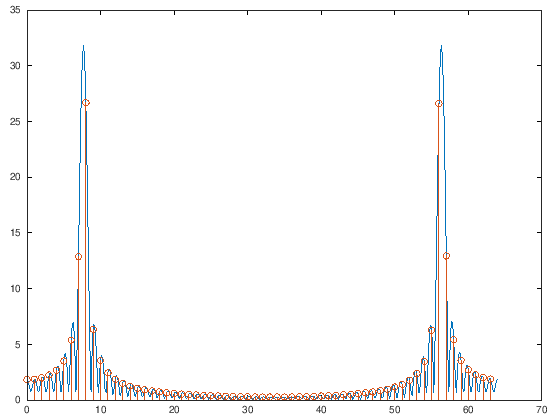

In [5]:
tfd = @(n) tfsd(n*Df) ;
n=0:(N-1);
f=0:Fe;
plot(f/Df,abs(tfsd(f))); hold on
stem(n,abs(tfd(n)));
F/Df

L'échantillonnage n'attrape pas les pics correctement car $F/\Delta_f=7,68$ n'est pas entier !

On peut changer le nombre de points N en M pour que ce rapport soit l'entier le plus proche de $8$
Soit $\Delta_f= \frac{F}{8} = \frac{F_e}{M}$.

Donc en observant $M=\frac{8\,F_e}{F}$ points on échantillonera le pic correctement. Cela revient **à exactement 8 période du signal sinusoidal pour couper le signal quand il est nul et ne pas faire de discontinuité !**

In [6]:
M=8*Fe/F

M =  66.667


Mais ce nombre n'est pas entier ! Il faut donc chercher le nombre p de périodes complètes qui soit un multiple de $T_e$ pour avoir à la fois un nombre entier d'échantillons et de périodes.

$$
M\,T_e =p\,T \implies  \frac{M}{p}=\frac{T}{T_e}=\frac{F_e}{F}=\frac{500}{60}=\frac{25}{3}=8,33
$$

On $3 M=25 p$ et la valeur de p se divisant par 3 la plus proche de 8,33 est 9, ce qui fait $p=9$ et $M=25p/3=75$

M =  75
Df =  6.6667
p =  9
nF =  9


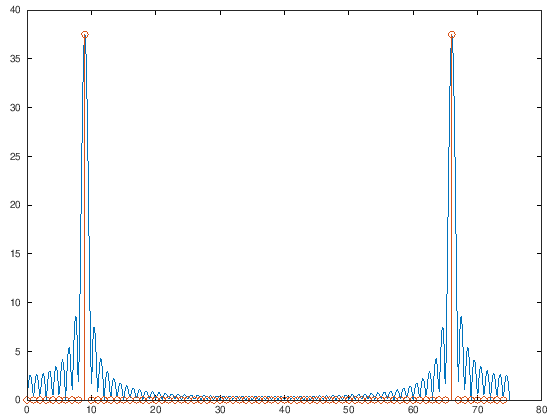

In [7]:
M=75
T0=M*Te;    % nouvelle durée d'observation
Df=Fe/M     % nouvelle résolution de fréquente
Df==1/T0;
p=T0/T      % nombre entier de périodes observées
nF=60/Df    % indice correspondant à F=60 Hz

k=0:(M-1);  % indice du temps
n=k  ;      % indices fréquences
bons = s(k*Te); % signal bien fenêtré;

% On recalcule tout avec la bonne fenêtre
Sporte= @(f) T0*sinc(f*T0);           % porte centrée largeur T0
Sretard= @(f,tau) exp(-tau*i*2*pi*f) ; % retard de tau
Sfenetre= @(f) Sretard(f,T0/2).* Sporte(f); % porte 0 à T0
Sf = @(f) 1/(2*i)*(-Sfenetre(f+F)+Sfenetre(f-F));
tfsd = @(f) 1/Te*Sf(f) + 1/Te*Sf(f-Fe)  + 1/Te*Sf(f+Fe) + ...
 1/Te*Sf(f-2*Fe)  + 1/Te*Sf(f+2*Fe);


plot(f/Df,abs(tfsd(f))); hold on
stem(n,abs(fft(bons)));